# Portfolio Cdar Optimizer
## MetaTrader 5 price data and trade execution 

In [1]:
pip install MetaTrader5


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


### Imports

In [3]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
pd.set_option('display.max_columns', 500) # number of columns to be displayed
pd.set_option('display.width', 1500)      # max table width to display
pd.set_option('display.max_rows', 5000)
import hvplot.pandas
import pypfopt
import matplotlib.pyplot as plt
from pypfopt.expected_returns import mean_historical_return
from pypfopt import plotting, base_optimizer, risk_models, expected_returns, EfficientSemivariance, objective_functions
from pypfopt.risk_models import risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier, EfficientCDaR
import seaborn as sns
import scipy.optimize as sco
import requests
from pathlib import Path
from dotenv import load_dotenv
import os
import platform
from pypfopt.plotting import plot_weights

print(platform.python_version())

3.7.13


In [4]:
# !pip list

## Connect to Metatrader and obtain account details

In [9]:
# Load variables from the .env file
load_dotenv("aaa.env")
# Access the variables
login = int(os.getenv("LOGIN"))
password = os.getenv("PASSWORD")
server = os.getenv("SERVER")
path_1_mt = os.getenv("path_1_mt")

In [10]:
#ThinkMarkets account
timeout = 10000
portable = False

if mt5.initialize(path=path_1_mt, login=login, password=password, server=server, timeout=timeout, portable=portable):
    print("Initialization successful")
    

Initialization successful


In [22]:
# Get account info
account_info_dict = mt5.account_info()._asdict()
# mt5.account_info()._asdict()
account_info_df = pd.DataFrame(account_info_dict, index=[0])


In [23]:
# display relevant information
print("Profit:", account_info_df["profit"].loc[0])
print("Equity:", account_info_df["equity"].loc[0])
print("Margin:", account_info_df["margin"].loc[0])
print("Margin Free:", account_info_df["margin_free"].loc[0])

Profit: 0.0
Equity: 99571.02
Margin: 0.0
Margin Free: 99571.02


## Retrieve daily data from Metatrader and concatenate into dataframe for PyportfolioOpt analyse

In [24]:
# Get bars function to recieve daily ticker data
def get_bars_data(symbol):

    # set time zone to UTC
    timezone = pytz.timezone("Etc/UTC")
    # create 'datetime' object in UTC time zone to avoid the implementation of a local time zone offset
    utc_from = datetime(2010, 11, 1, tzinfo=timezone)
    utc_to = datetime(2023, 12, 1, tzinfo=timezone)
    # get 10 EURUSD H4 bars starting from 01.10.2020 in UTC time zone
    rates = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_D1, utc_from, utc_to)
    # create DataFrame out of the obtained data
    rates_frame = pd.DataFrame(rates)
    # convert time in seconds into the datetime format
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
    #Set index to time
    rates_frame = rates_frame.set_index('time')
    # Remove unwanted columns
    rates_frame = rates_frame['close']
    # Change series into df
    rates_frame = pd.DataFrame(rates_frame)
    #Rename column to symbol
    rates_frame = rates_frame.rename(columns={'close':symbol})
    return rates_frame
    
    

In [25]:
# Call relevant tickers and save data into variable
EURUSDx = get_bars_data('EURUSDx')
AUDUSDx = get_bars_data('AUDUSDx')
GBPUSDx = get_bars_data('GBPUSDx')
USDJPYx = get_bars_data('USDJPYx')
USDCHFx = get_bars_data('USDCHFx')
XAUUSDx = get_bars_data('XAUUSDx')
XAUEURx = get_bars_data('XAUEURx')
XAGUSDx = get_bars_data('XAGUSDx')
GBPAUDx = get_bars_data('GBPAUDx')
EURAUDx = get_bars_data('EURAUDx')
AUDJPYx = get_bars_data('AUDJPYx')
BRENT = get_bars_data('BRENT')
NGAS = get_bars_data('NGAS')
COPPER = get_bars_data('COPPER')
WTI = get_bars_data('WTI')
BRENT = get_bars_data('BRENT')
WHEAT = get_bars_data('WHEAT')
CORN = get_bars_data('CORN')
SOYBEANS = get_bars_data('SOYBEANS')
ESTX50 = get_bars_data('ESTX50')
FRA40 = get_bars_data('FRA40')
GER40 = get_bars_data('GER40')
AUS200 = get_bars_data('AUS200')
UK100 = get_bars_data('UK100')
US30 = get_bars_data('US30')
JPN225 = get_bars_data('JPN225')
NAS100 = get_bars_data('NAS100')
SPX500 = get_bars_data('SPX500')
US2000 = get_bars_data('US2000')
ETHUSD = get_bars_data('ETHUSD')
BTCUSD = get_bars_data('BTCUSD')

In [69]:
# Concatenate dataframes
df = pd.concat([XAUUSDx,    
                ESTX50, FRA40, GER40, AUS200, UK100, US30, JPN225, NAS100, SPX500, US2000,
                WTI, AUDUSDx, EURAUDx, GBPAUDx, AUDJPYx   
               ], join='outer', axis=1)
df = df.dropna()
display(df.head(3))
display(df.tail(3))

# deleted these as they had the most nans SOYBEANS, XAUEURx,COPPER, NGAS, WHEAT, CORN, ETHUSD, BTCUSD, XAGUSDx, silver removed as lot size too small after optimization
# fx  GBPUSDx, AUDUSDx, USDCHFx,EURUSDx,USDJPYx

XAUUSDx    ESTX50     FRA40     GER40    AUS200     UK100       US30    JPN225    NAS100    SPX500   US2000     WTI  AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx
time                                                                                                                                                                
2012-08-30 1655.1800 2413.0000 3380.0000 6900.0000 4301.0000 5716.0000 12986.0000 8910.0000 2752.0000 1397.9000 807.1000 94.5500   1.0292   1.2145   1.5343  80.9060
2012-08-31 1690.8100 2438.0000 3400.0000 6957.0000 4339.0000 5710.0000 13092.0000 8880.0000 2771.0000 1407.4000 807.5000 96.5900   1.0319   1.2179   1.5357  80.8830
2012-09-03 1692.4200 2464.0000 3453.0000 7011.0000 4335.0000 5754.0000 13093.0000 8790.0000 2776.0000 1408.1000 817.0000 96.8300   1.0242   1.2284   1.5496  80.1760

XAUUSDx    ESTX50     FRA40      GER40    AUS200     UK100       US30     JPN225     NAS100    SPX500    US2000     WTI  AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx
time                                                                                                                                                                    
2023-11-29 2044.1100 4374.4500 7273.8800 16217.9200 7058.9700 7435.5800 35565.7500 33312.0000 16019.5900 4561.3700 1803.8600 77.7300   0.6617   1.6574   1.9180  97.4230
2023-11-30 2036.4100 4387.0900 7316.9600 16259.0500 7073.7800 7471.2200 35957.1500 33522.0000 15933.7900 4569.4200 1808.6100 75.6600   0.6605   1.6480   1.9109  97.8690
2023-12-01 2071.8100 4428.4100 7363.2800 16476.8900 7147.6400 7538.3200 36286.3300 33477.0000 16008.0400 4602.1200 1865.7600 74.4800   0.6675   1.6298   1.9038  98.0080

### Convert prices into AUD to give real returns for optimiser. Also add AUDUSD, EURUSD, AUDJPY, GBPAUD for currency conversions and to allow hedging in optimiser

In [71]:
df.to_csv('project_data.csv')

In [72]:
df.isna().sum()

XAUUSDx    0
ESTX50     0
FRA40      0
GER40      0
AUS200     0
UK100      0
US30       0
JPN225     0
NAS100     0
SPX500     0
US2000     0
WTI        0
AUDUSDx    0
EURAUDx    0
GBPAUDx    0
AUDJPYx    0
dtype: int64

In [75]:
# Function to perform multiple calculations and return a Series with results
def multiple_calculations(row):
    result = pd.Series(dtype=float)
    result['XAUUSDx'] = float(row['XAUUSDx'] * (1 / row['AUDUSDx']))
    # result['XAGUSDx'] = float(row['XAGUSDx'] * (1 / row['AUDUSDx']))
    result['ESTX50'] = float(row['ESTX50'] * row['EURAUDx'])
    result['FRA40'] = float(row['FRA40'] * row['EURAUDx'])
    result['GER40'] = float(row['GER40'] * row['EURAUDx'])
    result['UK100'] = float(row['UK100'] * row['GBPAUDx'])
    result['US30'] = float(row['US30'] * (1 / row['AUDUSDx']))
    result['JPN225'] = float(row['JPN225'] * (1 / row['AUDJPYx']))
    result['NAS100'] = float(row['NAS100'] * (1 / row['AUDUSDx']))
    result['SPX500'] = float(row['SPX500'] * (1 / row['AUDUSDx']))
    result['US2000'] = float(row['US2000'] * (1 / row['AUDUSDx']))
    result['WTI'] = float(row['WTI'] * (1 / row['AUDUSDx']))     

    return result

# Apply the function to create multiple new columns
df_aud = df.apply(multiple_calculations, axis=1)

df_aud

XAUUSDx    ESTX50      FRA40      GER40      UK100       US30   JPN225     NAS100    SPX500    US2000      WTI
time                                                                                                                       
2012-08-30 1608.1419 2930.6850  4105.1452  8380.3260  8770.0588 12616.9541 110.1278  2673.7916 1358.1734  784.1632  91.8630
2012-08-31 1638.5088 2969.3133  4140.9620  8473.1390  8768.8470 12687.0300 109.7882  2685.2857 1363.8654  782.5219  93.6022
2012-09-03 1652.4150 3026.8515  4241.7688  8612.5227  8916.5135 12783.5112 109.6338  2710.3817 1374.8157  797.6880  94.5412
2012-09-04 1658.4600 3004.1226  4189.7988  8545.4694  8820.1865 12747.2269 109.3567  2708.4923 1373.4178  804.4291  93.2762
2012-09-05 1660.6263 3010.6524  4205.7677  8604.3358  8825.2918 12809.2930 108.7332  2715.6957 1378.4510  807.2523  93.9407
2012-09-06 1653.3875 3101.0535  4308.3151  8794.7105  8950.7105 12919.9167 109.2734  2747.5734 1393.1413  814.8379  92.2018
2012-09-07 1671.3801 3132.7090  4342.6254  8908.4870  8924.6958 12810.1641 109.0338  2719.2340 1386.0099  806.8121  92.7603
2012-09-10 1670.2442 3102.6280  4308.3827  8872.2325  8924.8629 12804.4827 108.9250  2694.2544 1380.6118  810.5022  93.1279
2012-09-11 1660.7271 3146.2981  4351.1061  8990.4792  8911.0541 12754.9797 108.6112  2665.1194 1371.9755  805.4818  92.8812
2012-09-12 1654.0267 3153.6604  4365.0900  9041.9721  8894.7397 12763.9440 109.9239  2669.7892 1375.1374  809.0618  92.6540
2012-09-13 1675.4206 3171.3651  4361.8582  9090.5901  9003.5677 12838.8247 110.7915  2684.9902 1384.3206  812.2309  93.0689
2012-09-14 1677.9481 3212.9937  4443.2108  9189.9332  9061.1020 12880.7486 111.7589  2707.5453 1389.8922  813.4012  93.8445
2012-09-17 1681.6320 3227.2435  4439.0246  9248.5939  9104.8055 12935.8508 111.0653  2724.6942 1395.6775  821.2284  92.5899
2012-09-18 1694.5603 3183.3903  4384.6461  9174.7005  9116.9633 12990.7776 111.3351  2735.1523 1397.8073  821.6937  91.5544
2012-09-19 1689.9060 3193.7071  4395.2383  9188.9118  9118.1057 12953.5212 111.8490  2730.6752 1393.4082  816.5292  88.0118
2012-09-20 1695.6197 3171.3194  4369.2629  9184.6479  9104.2132 13038.4335 111.6532  2743.4698 1401.3655  819.5888  88.9878
2012-09-21 1695.3894 3188.6761  4369.8511  9233.5127  9058.1644 12979.7347 111.2009  2734.2368 1394.9485  818.9321  89.0372
2012-09-24 1691.7890 3173.6576  4343.9438  9197.4085  9090.5394 13011.3271 111.3356  2728.6765 1399.4418  818.3152  88.2864
2012-09-25 1695.1247 3149.8895  4313.7091  9127.9724  9047.7499 12980.3850 111.2871  2705.8518 1390.8656  810.1185  87.4346
2012-09-26 1689.4211 3100.5593  4243.2624  9032.4416  8985.1560 12956.5352 109.9519  2685.2173 1383.9716  803.2512  87.0454
2012-09-27 1701.2043 3116.6876  4272.1606  9055.9424  9014.6035 12917.4006 110.6643  2700.6587 1386.3253  807.9000  88.2668
2012-09-28 1707.8511 3043.4613  4158.2823  8965.6382  8943.8788 12947.9902 109.3756  2694.4463 1387.7940  813.1523  88.6681
2012-10-01 1714.1202 3079.9212  4235.5136  9046.9574  9011.0349 13043.4363 109.1094  2697.1435 1393.3793  810.8813  89.1322
2012-10-02 1728.9994 3135.4095  4290.4279  9199.8853  9122.4995 13130.5060 109.3047  2727.6448 1408.5523  818.6832  89.3136
2012-10-03 1739.5095 3141.7966  4292.1892  9241.0240  9146.0064 13231.4949 109.4693  2758.6409 1421.9869  821.3293  86.4191
2012-10-04 1747.4668 3167.7292  4336.2580  9301.2352  9234.1573 13248.0134 109.9915  2761.6705 1427.5952  824.2059  89.2735
2012-10-05 1747.3541 3217.4646  4391.8712  9420.8388  9246.3030 13353.4275 110.8310  2758.8509 1433.5225  830.1098  88.2538
2012-10-08 1741.3920 3180.7968  4343.2311  9290.5720  9188.1646 13323.3900 110.3118  2733.7579 1428.7957  822.5805  88.2731
2012-10-09 1728.1803 3103.8312  4251.9964  9108.3567  9084.9920 13159.9314 108.2218  2678.4227 1407.8864  810.6784  89.9927
2012-10-10 1724.3077 3076.0258  4218.6934  9045.8038  9030.7140 13017.9078 106.5623  2664.6443 1396.8099  806.6347  89.2945
2012-10-11 1721.4509 3114.0758  4271.3082  91

In [76]:
df_forex = df[['AUDUSDx', 'EURAUDx', 'GBPAUDx', 'AUDJPYx']]
df_forex

AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx
time                                          
2012-08-30   1.0292   1.2145   1.5343  80.9060
2012-08-31   1.0319   1.2179   1.5357  80.8830
2012-09-03   1.0242   1.2284   1.5496  80.1760
2012-09-04   1.0223   1.2287   1.5520  80.1780
2012-09-05   1.0193   1.2359   1.5598  79.9020
2012-09-06   1.0282   1.2281   1.5494  81.0810
2012-09-07   1.0382   1.2333   1.5406  81.1950
2012-09-10   1.0333   1.2341   1.5468  80.8630
2012-09-11   1.0427   1.2319   1.5398  81.1150
2012-09-12   1.0461   1.2324   1.5383  81.4200
2012-09-13   1.0544   1.2311   1.5317  81.6850
2012-09-14   1.0548   1.2439   1.5358  82.6690
2012-09-17   1.0471   1.2518   1.5508  82.4200
2012-09-18   1.0453   1.2474   1.5534  82.3370
2012-09-19   1.0474   1.2451   1.5475  82.0660
2012-09-20   1.0428   1.2427   1.5536  81.5830
2012-09-21   1.0456   1.2407   1.5508  81.7170
2012-09-24   1.0426   1.2397   1.5558  81.1600
2012-09-25   1.0385   1.2421   1.5575  80.7910
2012-09-26   1.0372   1.2407   1.5586  80.6080
2012-09-27   1.0446   1.2358   1.5545  81.0740
2012-09-28   1.0377   1.2387   1.5565  80.8590
2012-10-01   1.0355   1.2439   1.5563  80.7630
2012-10-02   1.0262   1.2582   1.5715  80.2070
2012-10-03   1.0219   1.2628   1.5728  80.1960
2012-10-04   1.0244   1.2701   1.5806  80.3880
2012-10-05   1.0185   1.2793   1.5830  80.1130
2012-10-08   1.0191   1.2718   1.5720  79.7920
2012-10-09   1.0208   1.2617   1.5680  79.8730
2012-10-10   1.0219   1.2571   1.5638  79.8500
2012-10-11   1.0264   1.2592   1.5629  80.4620
2012-10-12   1.0232   1.2651   1.5699  80.2380
2012-10-15   1.0251   1.2624   1.5671  80.6620
2012-10-16   1.0302   1.2708   1.5680  81.2340
2012-10-17   1.0373   1.2639   1.5551  81.9880
2012-10-18   1.0367   1.2601   1.5476  82.1870
2012-10-19   1.0327   1.2599   1.5476  81.8720
2012-10-22   1.0327   1.2646   1.5509  82.5330
2012-10-23   1.0265   1.2644   1.5538  81.9720
2012-10-24   1.0348   1.2529   1.5487  82.5630
2012-10-25   1.0355   1.2493   1.5575  83.1960
2012-10-26   1.0371   1.2469   1.5516  82.5870
2012-10-29   1.0326   1.2492   1.5510  82.3610
2012-10-30   1.0369   1.2500   1.5510  82.5260
2012-10-31   1.0369   1.2492   1.5542  82.7500
2012-11-01   1.0413   1.2428   1.5500  83.4640
2012-11-02   1.0335   1.2411   1.5485  83.0920
2012-11-05   1.0371   1.2334   1.5413  83.1910
2012-11-06   1.0428   1.2279   1.5336  83.8140
2012-11-07   1.0403   1.2271   1.5349  83.1530
2012-11-08   1.0400   1.2248   1.5355  82.6490
2012-11-09   1.0385   1.2233   1.5297  82.5140
2012-11-12   1.0426   1.2183   1.5223  82.9260
2012-11-13   1.0431   1.2172   1.5206  82.8440
2012-11-14   1.0362   1.2283   1.5264  83.0590
2012-11-15   1.0330   1.2367   1.5350  83.7940
2012-11-16   1.0338   1.2320   1.5353  84.0480
2012-11-19   1.0409   1.2273   1.5274  84.6220
2012-11-20   1.0383   1.2335   1.5326  84.7890
2012-11-21   1.0366   1.2369   1.5382  85.5280
2012-11-22   1.0384   1.2398   1.5336  85.6100
2012-11-23   1.0459   1.2396   1.5313  86.1550
2012-11-26   1.0466   1.2410   1.5316  85.8650
2012-11-27   1.0443   1.2383   1.5333  85.7180
2012-11-28   1.0477   1.2355   1.5283  85.9890
2012-11-29   1.0430   1.2437   1.5371  85.6430
2012-11-30   1.0426   1.2449   1.5348  85.9770
2012-12-03   1.0422   1.2525   1.5440  85.6350
2012-12-04   1.0466   1.2506   1.5370  85.6950
2012-12-05   1.0451   1.2501   1.5386  86.1350
2012-12-06   1.0470   1.2371   1.5305  86.2730
2012-12-07   1.0485   1.2321   1.5285  86.4730
2012-12-10   1.0485   1.2336   1.5324  86.3300
2012-12-11   1.0535   1.2343   1.5302  86.9390
2012-12-12   1.0549   1.2385   1.5301  87.7380
2012-12-13   1.0524   1.2418   1.5302  87.9930
2012-12-14   1.0565   1.2453   1.5297  88.2090
2012-12-17   1.0545   1.2475   1.5351  88.4340
2012-12-18   1.0517   1.2568   1.5425  88.6200
2012-12-19   1.0475   1.2595   1.5498  88.0550
2012-12-20   1.0476   1.2638   1.5526  88.3560
2012-12-21   1.0396   1.2670   1.5534  87.6010
2012-12-27   1.0364   1.2765   1.5510  89.3870
2012-12-28   1.03

In [77]:
# Concatenate the new columns to the original DataFrame
df_aud_fx = pd.concat([df_forex, df_aud], axis=1)
df_aud_fx

AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx   XAUUSDx    ESTX50      FRA40      GER40      UK100       US30   JPN225     NAS100    SPX500    US2000      WTI
time                                                                                                                                                           
2012-08-30   1.0292   1.2145   1.5343  80.9060 1608.1419 2930.6850  4105.1452  8380.3260  8770.0588 12616.9541 110.1278  2673.7916 1358.1734  784.1632  91.8630
2012-08-31   1.0319   1.2179   1.5357  80.8830 1638.5088 2969.3133  4140.9620  8473.1390  8768.8470 12687.0300 109.7882  2685.2857 1363.8654  782.5219  93.6022
2012-09-03   1.0242   1.2284   1.5496  80.1760 1652.4150 3026.8515  4241.7688  8612.5227  8916.5135 12783.5112 109.6338  2710.3817 1374.8157  797.6880  94.5412
2012-09-04   1.0223   1.2287   1.5520  80.1780 1658.4600 3004.1226  4189.7988  8545.4694  8820.1865 12747.2269 109.3567  2708.4923 1373.4178  804.4291  93.2762
2012-09-05   1.0193   1.2359   1.5598  79.9020 1660.6263 3010.6524  4205.7677  8604.3358  8825.2918 12809.2930 108.7332  2715.6957 1378.4510  807.2523  93.9407
2012-09-06   1.0282   1.2281   1.5494  81.0810 1653.3875 3101.0535  4308.3151  8794.7105  8950.7105 12919.9167 109.2734  2747.5734 1393.1413  814.8379  92.2018
2012-09-07   1.0382   1.2333   1.5406  81.1950 1671.3801 3132.7090  4342.6254  8908.4870  8924.6958 12810.1641 109.0338  2719.2340 1386.0099  806.8121  92.7603
2012-09-10   1.0333   1.2341   1.5468  80.8630 1670.2442 3102.6280  4308.3827  8872.2325  8924.8629 12804.4827 108.9250  2694.2544 1380.6118  810.5022  93.1279
2012-09-11   1.0427   1.2319   1.5398  81.1150 1660.7271 3146.2981  4351.1061  8990.4792  8911.0541 12754.9797 108.6112  2665.1194 1371.9755  805.4818  92.8812
2012-09-12   1.0461   1.2324   1.5383  81.4200 1654.0267 3153.6604  4365.0900  9041.9721  8894.7397 12763.9440 109.9239  2669.7892 1375.1374  809.0618  92.6540
2012-09-13   1.0544   1.2311   1.5317  81.6850 1675.4206 3171.3651  4361.8582  9090.5901  9003.5677 12838.8247 110.7915  2684.9902 1384.3206  812.2309  93.0689
2012-09-14   1.0548   1.2439   1.5358  82.6690 1677.9481 3212.9937  4443.2108  9189.9332  9061.1020 12880.7486 111.7589  2707.5453 1389.8922  813.4012  93.8445
2012-09-17   1.0471   1.2518   1.5508  82.4200 1681.6320 3227.2435  4439.0246  9248.5939  9104.8055 12935.8508 111.0653  2724.6942 1395.6775  821.2284  92.5899
2012-09-18   1.0453   1.2474   1.5534  82.3370 1694.5603 3183.3903  4384.6461  9174.7005  9116.9633 12990.7776 111.3351  2735.1523 1397.8073  821.6937  91.5544
2012-09-19   1.0474   1.2451   1.5475  82.0660 1689.9060 3193.7071  4395.2383  9188.9118  9118.1057 12953.5212 111.8490  2730.6752 1393.4082  816.5292  88.0118
2012-09-20   1.0428   1.2427   1.5536  81.5830 1695.6197 3171.3194  4369.2629  9184.6479  9104.2132 13038.4335 111.6532  2743.4698 1401.3655  819.5888  88.9878
2012-09-21   1.0456   1.2407   1.5508  81.7170 1695.3894 3188.6761  4369.8511  9233.5127  9058.1644 12979.7347 111.2009  2734.2368 1394.9485  818.9321  89.0372
2012-09-24   1.0426   1.2397   1.5558  81.1600 1691.7890 3173.6576  4343.9438  9197.4085  9090.5394 13011.3271 111.3356  2728.6765 1399.4418  818.3152  88.2864
2012-09-25   1.0385   1.2421   1.5575  80.7910 1695.1247 3149.8895  4313.7091  9127.9724  9047.7499 12980.3850 111.2871  2705.8518 1390.8656  810.1185  87.4346
2012-09-26   1.0372   1.2407   1.5586  80.6080 1689.4211 3100.5593  4243.2624  9032.4416  8985.1560 12956.5352 109.9519  2685.2173 1383.9716  803.2512  87.0454
2012-09-27   1.0446   1.2358   1.5545  81.0740 1701.2043 3116.6876  4272.1606  9055.9424  9014.6035 12917.4006 110.6643  2700.6587 1386.3253  807.9000  88.2668
2012-09-28   1.0377   1.2387   1.5565  80.8590 1707.8511 3043.4613  4158.2823  8965.6382  8943.8788 12947.9902 109.3756  2694.4463 1387.7940  813.1523  88.6681
2012-10-01   1.0355   1.2439   1.5563  80.7630 1714.1202 3079.9212  4235.5136  9046.9574  9011.0349 13043.4363 109.1094  2697.1435 1393.3793  810.8813  89.1322
2012-10-02  

In [78]:
df_aud.isna().sum()

XAUUSDx    0
ESTX50     0
FRA40      0
GER40      0
UK100      0
US30       0
JPN225     0
NAS100     0
SPX500     0
US2000     0
WTI        0
dtype: int64

In [79]:
df_aud.to_csv('project_data_aud.csv')

In [80]:
# Function to calculate average gain for each column
def calculate_average_gain(column):
    first_row = column.iloc[0]  # First row value
    last_row = column.iloc[-1]  # Last row value
    average_gain = ((last_row - first_row) / first_row) * 100
    return average_gain

# Loop through each column in the DataFrame
for col in df_aud_fx.columns:
    avg_gain = calculate_average_gain(df_aud_fx[col])
    print(f"Column '{col}': Average Gain = {avg_gain}")

    

Column 'AUDUSDx': Average Gain = -35.15083798882681
Column 'EURAUDx': Average Gain = 34.18989905643288
Column 'GBPAUDx': Average Gain = 24.084598839861833
Column 'AUDJPYx': Average Gain = 21.138110894124033
Column 'XAUUSDx': Average Gain = 93.01911787757275
Column 'ESTX50': Average Gain = 146.26932900144962
Column 'FRA40': Average Gain = 192.33071003676065
Column 'GER40': Average Gain = 220.43945012520996
Column 'UK100': Average Gain = 63.64405408091447
Column 'US30': Average Gain = 330.88688828652135
Column 'JPN225': Average Gain = 210.1616022824496
Column 'NAS100': Average Gain = 796.9853764645071
Column 'SPX500': Average Gain = 407.665283491842
Column 'US2000': Average Gain = 256.47088328165404
Column 'WTI': Average Gain = 21.471324322364158


In [81]:
#Calculate daily change stocks
combined_returns = df_aud_fx.pct_change()
combined_returns = combined_returns.dropna()

display(combined_returns)

AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx  XAUUSDx  ESTX50   FRA40   GER40   UK100    US30  JPN225  NAS100  SPX500  US2000     WTI
time                                                                                                                                   
2012-08-31   0.0026   0.0028   0.0009  -0.0003   0.0189  0.0132  0.0087  0.0111 -0.0001  0.0056 -0.0031  0.0043  0.0042 -0.0021  0.0189
2012-09-03  -0.0075   0.0086   0.0091  -0.0087   0.0085  0.0194  0.0243  0.0165  0.0168  0.0076 -0.0014  0.0093  0.0080  0.0194  0.0100
2012-09-04  -0.0018   0.0002   0.0016   0.0000   0.0037 -0.0075 -0.0123 -0.0078 -0.0108 -0.0028 -0.0025 -0.0007 -0.0010  0.0085 -0.0134
2012-09-05  -0.0030   0.0059   0.0050  -0.0034   0.0013  0.0022  0.0038  0.0069  0.0006  0.0049 -0.0057  0.0027  0.0037  0.0035  0.0071
2012-09-06   0.0088  -0.0063  -0.0067   0.0148  -0.0044  0.0300  0.0244  0.0221  0.0142  0.0086  0.0050  0.0117  0.0107  0.0094 -0.0185
2012-09-07   0.0097   0.0042  -0.0057   0.0014   0.0109  0.0102  0.0080  0.0129 -0.0029 -0.0085 -0.0022 -0.0103 -0.0051 -0.0098  0.0061
2012-09-10  -0.0047   0.0006   0.0040  -0.0041  -0.0007 -0.0096 -0.0079 -0.0041  0.0000 -0.0004 -0.0010 -0.0092 -0.0039  0.0046  0.0040
2012-09-11   0.0091  -0.0018  -0.0045   0.0031  -0.0057  0.0141  0.0099  0.0133 -0.0015 -0.0039 -0.0029 -0.0108 -0.0063 -0.0062 -0.0026
2012-09-12   0.0033   0.0004  -0.0010   0.0038  -0.0040  0.0023  0.0032  0.0057 -0.0018  0.0007  0.0121  0.0018  0.0023  0.0044 -0.0024
2012-09-13   0.0079  -0.0010  -0.0043   0.0033   0.0129  0.0056 -0.0007  0.0054  0.0122  0.0059  0.0079  0.0057  0.0067  0.0039  0.0045
2012-09-14   0.0004   0.0104   0.0026   0.0120   0.0015  0.0131  0.0187  0.0109  0.0064  0.0033  0.0087  0.0084  0.0040  0.0014  0.0083
2012-09-17  -0.0073   0.0064   0.0098  -0.0030   0.0022  0.0044 -0.0009  0.0064  0.0048  0.0043 -0.0062  0.0063  0.0042  0.0096 -0.0134
2012-09-18  -0.0017  -0.0035   0.0017  -0.0010   0.0077 -0.0136 -0.0123 -0.0080  0.0013  0.0042  0.0024  0.0038  0.0015  0.0006 -0.0112
2012-09-19   0.0020  -0.0018  -0.0038  -0.0033  -0.0027  0.0032  0.0024  0.0015  0.0001 -0.0029  0.0046 -0.0016 -0.0031 -0.0063 -0.0387
2012-09-20  -0.0043  -0.0020   0.0039  -0.0059   0.0034 -0.0070 -0.0059 -0.0005 -0.0015  0.0066 -0.0018  0.0047  0.0057  0.0037  0.0111
2012-09-21   0.0027  -0.0016  -0.0018   0.0016  -0.0001  0.0055  0.0001  0.0053 -0.0051 -0.0045 -0.0041 -0.0034 -0.0046 -0.0008  0.0006
2012-09-24  -0.0029  -0.0008   0.0032  -0.0068  -0.0021 -0.0047 -0.0059 -0.0039  0.0036  0.0024  0.0012 -0.0020  0.0032 -0.0008 -0.0084
2012-09-25  -0.0040   0.0019   0.0011  -0.0045   0.0020 -0.0075 -0.0070 -0.0075 -0.0047 -0.0024 -0.0004 -0.0084 -0.0061 -0.0100 -0.0096
2012-09-26  -0.0013  -0.0011   0.0007  -0.0023  -0.0034 -0.0157 -0.0163 -0.0105 -0.0069 -0.0018 -0.0120 -0.0076 -0.0050 -0.0085 -0.0045
2012-09-27   0.0071  -0.0040  -0.0026   0.0058   0.0070  0.0052  0.0068  0.0026  0.0033 -0.0030  0.0065  0.0058  0.0017  0.0058  0.0140
2012-09-28  -0.0066   0.0023   0.0013  -0.0027   0.0039 -0.0235 -0.0267 -0.0100 -0.0078  0.0024 -0.0116 -0.0023  0.0011  0.0065  0.0045
2012-10-01  -0.0021   0.0042  -0.0001  -0.0012   0.0037  0.0120  0.0186  0.0091  0.0075  0.0074 -0.0024  0.0010  0.0040 -0.0028  0.0052
2012-10-02  -0.0091   0.0115   0.0098  -0.0069   0.0087  0.0180  0.0130  0.0169  0.0124  0.0067  0.0018  0.0113  0.0109  0.0096  0.0020
2012-10-03  -0.0042   0.0036   0.0009  -0.0001   0.0061  0.0020  0.0004  0.0045  0.0026  0.0077  0.0015  0.0114  0.0095  0.0032 -0.0324
2012-10-04   0.0024   0.0058   0.0050   0.0024   0.0046  0.0083  0.0103  0.0065  0.0096  0.0012  0.0048  0.0011  0.0039  0.0035  0.0330
2012-10-05  -0.0057   0.0072   0.0015  -0.0034  -0.0001  0.0157  0.0128  0.0129  0.0013  0.0080  0.0076 -0.0010  0.0042  0.0072 -0.0114
2012-10-08   0.0006  -0.0059  -0.0070  -0.0040  -0.0034 -0.0114 -0.0111 -0.0138 -0.0063 -0.0022 -0.0047 -0.0091 -0.0033 -0.0091  0.0002
2012-10-09   0.0016  -0.0079  -0.0025   0.0010  -0.0076 -0.0242 -0.0

## Analyse data

In [82]:
# Plot returns to visualise data

cum_returns_index = (1 + combined_returns).cumprod(axis=0)
cum_returns_index

# Plot cumulative returns
cum_returns_index.hvplot(
    width=1500,
    height=900,
    rot=45
)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [83]:
# Calculate the annualized `std`
portfolio_std = combined_returns.std() * np.sqrt(252)
#portfolio_std.plot(kind="bar", title="Sharpe Ratios")
portfolio_std.hvplot.bar( title="annualised standard deviation", rot=45)

:Bars   [index]   (0)

In [84]:
#Plot covariance
co_var = risk_models.risk_matrix(df_aud_fx, method='sample_cov')
co_var

AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx  XAUUSDx  ESTX50   FRA40   GER40   UK100    US30  JPN225  NAS100  SPX500  US2000     WTI
AUDUSDx   0.0105  -0.0063  -0.0053   0.0079  -0.0048  0.0004  0.0001  0.0002 -0.0002 -0.0036 -0.0025 -0.0025 -0.0031 -0.0015 -0.0008
EURAUDx  -0.0063   0.0085   0.0056  -0.0065   0.0048  0.0017  0.0019  0.0018  0.0003  0.0007  0.0004 -0.0000  0.0005 -0.0010 -0.0017
GBPAUDx  -0.0053   0.0056   0.0089  -0.0049   0.0034  0.0025  0.0025  0.0026  0.0042  0.0021  0.0018  0.0015  0.0020  0.0013  0.0014
AUDJPYx   0.0079  -0.0065  -0.0049   0.0140  -0.0079  0.0063  0.0059  0.0056  0.0049  0.0027  0.0025  0.0035  0.0030  0.0053  0.0056
XAUUSDx  -0.0048   0.0048   0.0034  -0.0079   0.0209 -0.0037 -0.0035 -0.0033 -0.0024 -0.0017 -0.0011 -0.0020 -0.0018 -0.0032  0.0015
ESTX50    0.0004   0.0017   0.0025   0.0063  -0.0037  0.0352  0.0336  0.0332  0.0251  0.0212  0.0183  0.0235  0.0217  0.0249  0.0139
FRA40     0.0001   0.0019   0.0025   0.0059  -0.0035  0.0336  0.0340  0.0315  0.0249  0.0206  0.0173  0.0219  0.0209  0.0242  0.0143
GER40     0.0002   0.0018   0.0026   0.0056  -0.0033  0.0332  0.0315  0.0346  0.0241  0.0206  0.0175  0.0230  0.0210  0.0246  0.0116
UK100    -0.0002   0.0003   0.0042   0.0049  -0.0024  0.0251  0.0249  0.0241  0.0261  0.0184  0.0148  0.0183  0.0182  0.0214  0.0182
US30     -0.0036   0.0007   0.0021   0.0027  -0.0017  0.0212  0.0206  0.0206  0.0184  0.0248  0.0161  0.0244  0.0237  0.0254  0.0148
JPN225   -0.0025   0.0004   0.0018   0.0025  -0.0011  0.0183  0.0173  0.0175  0.0148  0.0161  0.0255  0.0191  0.0169  0.0186  0.0091
NAS100   -0.0025  -0.0000   0.0015   0.0035  -0.0020  0.0235  0.0219  0.0230  0.0183  0.0244  0.0191  0.0383  0.0282  0.0291  0.0110
SPX500   -0.0031   0.0005   0.0020   0.0030  -0.0018  0.0217  0.0209  0.0210  0.0182  0.0237  0.0169  0.0282  0.0250  0.0266  0.0139
US2000   -0.0015  -0.0010   0.0013   0.0053  -0.0032  0.0249  0.0242  0.0246  0.0214  0.0254  0.0186  0.0291  0.0266  0.0402  0.0169
WTI      -0.0008  -0.0017   0.0014   0.0056   0.0015  0.0139  0.0143  0.0116  0.0182  0.0148  0.0091  0.0110  0.0139  0.0169  0.1602

<AxesSubplot:>

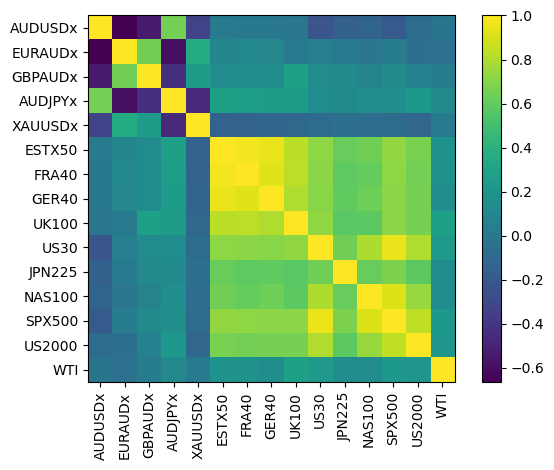

In [85]:
plotting.plot_covariance(co_var, plot_correlation=True, show_tickers=True)

## Generate Effcicent Frontier with AUD returns

In [86]:
mu = expected_returns.mean_historical_return(df_aud_fx, returns_data=False, compounding=True, frequency=252, log_returns=False)
S = risk_models.sample_cov(df_aud_fx, returns_data=False, frequency=252, log_returns=False)


### Max Sharpe Long only

OrderedDict([('AUDUSDx', 0.0), ('EURAUDx', 0.0), ('GBPAUDx', 0.0), ('AUDJPYx', 0.0), ('XAUUSDx', 0.31635), ('ESTX50', 0.0), ('FRA40', 0.0), ('GER40', 0.0), ('UK100', 0.0), ('US30', 0.0), ('JPN225', 0.0), ('NAS100', 0.68365), ('SPX500', 0.0), ('US2000', 0.0), ('WTI', 0.0)])
Expected annual return: 16.8%
Annual volatility: 13.8%
Sharpe Ratio: 1.07


<AxesSubplot:xlabel='Weight'>

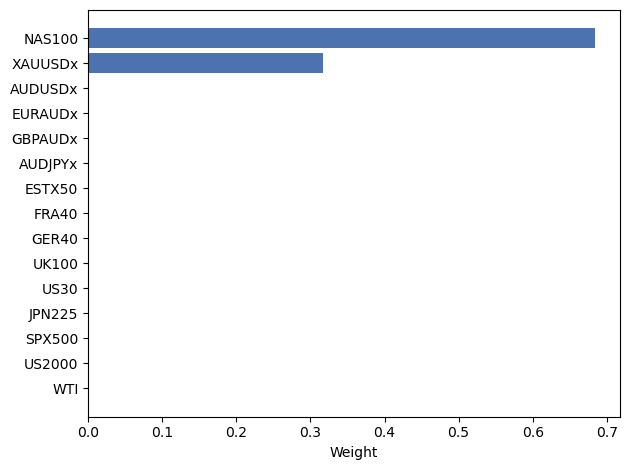

In [87]:
# Optimize the max sharpe ratio
ef = EfficientFrontier(mu,S,verbose=False, weight_bounds=(0,1))
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights, ax=None)

## Max Sharpe Ratio with shorts

OrderedDict([('AUDUSDx', -0.27327), ('EURAUDx', -0.07303), ('GBPAUDx', 0.24293), ('AUDJPYx', 0.49395), ('XAUUSDx', 0.31894), ('ESTX50', -1.0), ('FRA40', 0.79146), ('GER40', 0.4654), ('UK100', -0.63541), ('US30', 0.28815), ('JPN225', 0.04191), ('NAS100', 0.52967), ('SPX500', 0.06653), ('US2000', -0.24846), ('WTI', -0.00879)])
Expected annual return: 20.0%
Annual volatility: 12.2%
Sharpe Ratio: 1.47


<AxesSubplot:xlabel='Weight'>

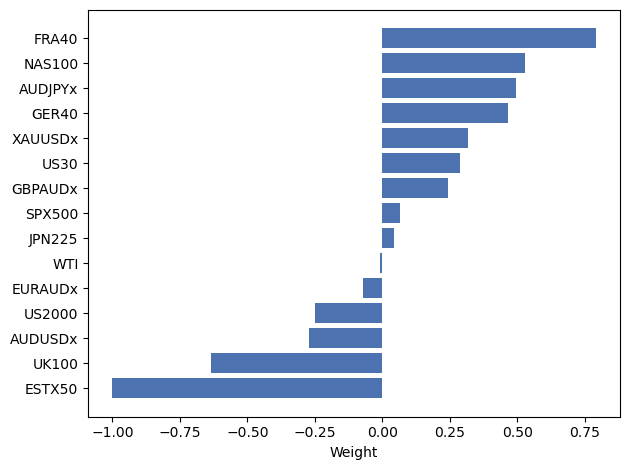

In [88]:
# Optimize the max sharpe ratio
ef = EfficientFrontier(mu,S,verbose=False, weight_bounds=(None, None))
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights, ax=None)

## Efficient Cdar with orginal prices eg USD for US indicies


In [89]:
mu_2 = expected_returns.mean_historical_return(df, returns_data=False, compounding=True, frequency=252, log_returns=False)
historical_returns_df = expected_returns.returns_from_prices(df).dropna()

XAUUSDx  ESTX50  FRA40  GER40  AUS200   UK100   US30  JPN225  NAS100  SPX500  US2000     WTI  AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx
0   0.8494 -1.0000 1.0000 0.1270 -0.2261 -0.9419 1.0000  0.8426  0.7606 -0.4654 -0.5124 -0.0169  -1.0000   0.4825  -0.4326   0.5333

Expected annual return: 30.3%
Conditional Drawdown at Risk: 15.00%


<AxesSubplot:xlabel='Weight'>

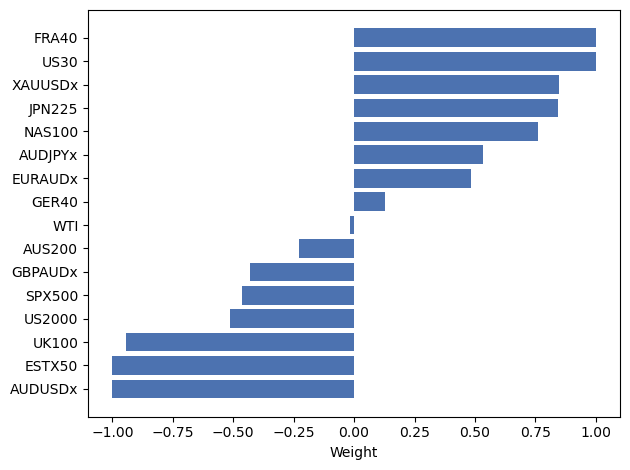

In [90]:
ef_cdar = EfficientCDaR(mu_2, historical_returns_df, weight_bounds=(None,None), beta=0.99, verbose=False)

weights = ef_cdar.efficient_risk(0.15, market_neutral=False)
cleaned_weights = ef_cdar.clean_weights()
cleaned_weights_1 = pd.DataFrame(cleaned_weights, index=[0])
display(cleaned_weights_1)
ef_cdar.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights, ax=None)


### Cdar with AUD returns and FX

In [91]:
mu_aud_fx = expected_returns.mean_historical_return(df_aud_fx, returns_data=False, compounding=True, frequency=252, log_returns=False)
historical_returns_aud_fx = expected_returns.returns_from_prices(df_aud_fx).dropna()

Expected annual return: 30.7%
Conditional Drawdown at Risk: 15.00%


AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx  XAUUSDx  ESTX50  FRA40  GER40   UK100   US30  JPN225  NAS100  SPX500  US2000     WTI
0  -0.7149  -0.4989  -0.2170   0.6911   0.8014 -1.0000 1.0000 0.2709 -0.6098 1.0000  0.4714  0.6871 -0.6115 -0.2160 -0.0539

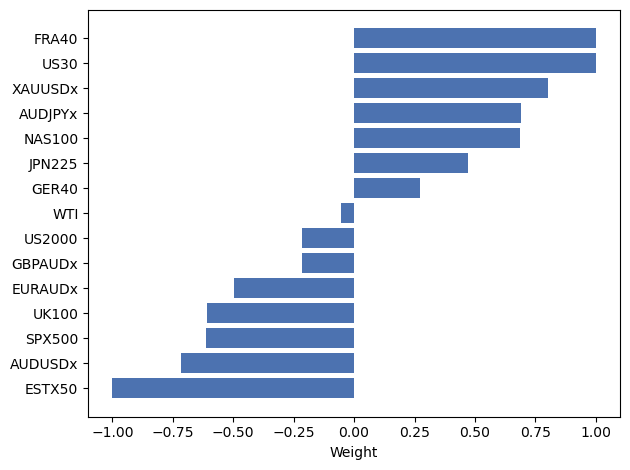

In [92]:
ef_cdar_aud_fx = EfficientCDaR(mu_aud_fx, historical_returns_aud_fx, weight_bounds=(None, None), beta=0.99, verbose=False)
# ef_cdar.add_objective(objective_functions.L2_reg, gamma=.3)
weights_aud_fx = ef_cdar_aud_fx.efficient_risk(0.15, market_neutral=False)
cleaned_weights_aud_fx = ef_cdar_aud_fx.clean_weights()
ef_cdar_aud_fx.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights_aud_fx, ax=None)

# Create dataframe for weight to be easily displayed
cleaned_weights_2 = pd.DataFrame(cleaned_weights_aud_fx, index=[0])
display(cleaned_weights_2)

In [93]:
# Compare portfolio weightings between original prices and AUD coverted prices
display(cleaned_weights_1) # Original price optimisation
display(cleaned_weights_2) # AUD price optimisation

XAUUSDx  ESTX50  FRA40  GER40  AUS200   UK100   US30  JPN225  NAS100  SPX500  US2000     WTI  AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx
0   0.8494 -1.0000 1.0000 0.1270 -0.2261 -0.9419 1.0000  0.8426  0.7606 -0.4654 -0.5124 -0.0169  -1.0000   0.4825  -0.4326   0.5333

AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx  XAUUSDx  ESTX50  FRA40  GER40   UK100   US30  JPN225  NAS100  SPX500  US2000     WTI
0  -0.7149  -0.4989  -0.2170   0.6911   0.8014 -1.0000 1.0000 0.2709 -0.6098 1.0000  0.4714  0.6871 -0.6115 -0.2160 -0.0539

# Cdar with AUD returns only, no forex

In [94]:
mu_aud = expected_returns.mean_historical_return(df_aud, returns_data=False, compounding=True, frequency=252, log_returns=False)
historical_returns_aud = expected_returns.returns_from_prices(df_aud).dropna()

XAUUSDx  ESTX50  FRA40  GER40   UK100   US30  JPN225  NAS100  SPX500  US2000    WTI
0   0.4833 -0.9771 1.0000 0.1810 -0.5415 0.2603  0.0665  0.1752  0.3499 -0.0304 0.0328

Expected annual return: 17.7%
Conditional Drawdown at Risk: 10.00%


<AxesSubplot:xlabel='Weight'>

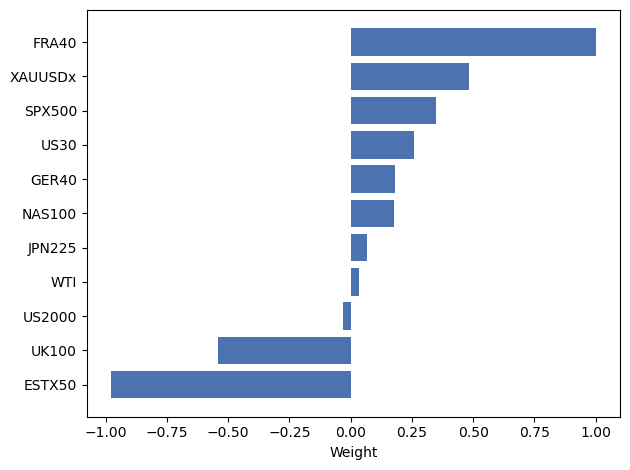

In [95]:
ef_cdar_aud = EfficientCDaR(mu_aud, historical_returns_aud, weight_bounds=(-1,1), beta=0.99, verbose=False)

weights_aud = ef_cdar_aud.efficient_risk(0.10, market_neutral=False)
cleaned_weights_aud = ef_cdar_aud.clean_weights()
cleaned_weights_3 = pd.DataFrame(cleaned_weights_aud, index=[0])
display(cleaned_weights_3)
ef_cdar_aud.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights_aud, ax=None)

## Portfolio calc for AUD_FX optimiser

In [96]:
# Convert the EfficientCDaR result to a DataFrame for AUD returns
cleaned_weights_aud_fx_df = pd.DataFrame(list(cleaned_weights_aud_fx.items()), columns=['Asset', 'Weight'])

# Convert the 'Weight' column to absolute values
cleaned_weights_aud_fx_df['Weight_Absolute'] = cleaned_weights_aud_fx_df['Weight'].abs()

# Calculate the absolute sum of weights
abs_sum_weights_aud_fx = cleaned_weights_aud_fx_df['Weight_Absolute'].sum()

# Establish connection to MetaTrader 5 terminal and retrieve account balance
if not mt5.initialize():
    print("initialize() failed")
    
else:
    # Request account information
    account_info = mt5.account_info()
    if account_info:
        # Store the balance value as a float variable
        total_portfolio_value_aud = float(account_info.balance)
        print(f"Account Balance: {total_portfolio_value_aud}")
    else:
        print("Failed to retrieve account information")

# Calculate the position size for 1 full position
position_size_aud_fx = total_portfolio_value_aud / abs_sum_weights_aud_fx

# Calculate the position size for each asset with no negatives
cleaned_weights_aud_fx_df['Position_Size_AUD'] = cleaned_weights_aud_fx_df['Weight_Absolute'] * position_size_aud_fx

# Replace negative position sizes with zero
cleaned_weights_aud_fx_df['Position_Size_AUD'] = cleaned_weights_aud_fx_df['Position_Size_AUD'].apply(lambda x: max(x, 0))

# Display the absolute values and position sizes for AUD returns
print("Absolute Values and Position Sizes for AUD Returns:")
display(cleaned_weights_aud_fx_df[['Asset', 'Weight_Absolute', 'Position_Size_AUD']])

# Validate that the sum of position sizes equals the total portfolio value
print("\nTotal Portfolio Value for AUD Returns:", cleaned_weights_aud_fx_df['Position_Size_AUD'].sum())

Account Balance: 99366.19
Absolute Values and Position Sizes for AUD Returns:


Asset  Weight_Absolute  Position_Size_AUD
0   AUDUSDx           0.7149          8032.4431
1   EURAUDx           0.4989          5604.8793
2   GBPAUDx           0.2170          2437.7882
3   AUDJPYx           0.6911          7765.3729
4   XAUUSDx           0.8014          9003.8732
5    ESTX50           1.0000         11235.6005
6     FRA40           1.0000         11235.6005
7     GER40           0.2709          3043.9489
8     UK100           0.6098          6850.9074
9      US30           1.0000         11235.6005
10   JPN225           0.4714          5296.3497
11   NAS100           0.6871          7720.2058
12   SPX500           0.6115          6870.4573
13   US2000           0.2160          2427.0021
14      WTI           0.0539           606.1606


Total Portfolio Value for AUD Returns: 99366.18999999999


### Lot sizing for assets, specific for ThinkMarkets

In [97]:
# Function to retrieve latest price data to be able to calculate the lot size

def get_latest_price(symbol):
    
    # Request symbol data
    symbol_info = mt5.symbol_info(symbol)

    if symbol_info is None:
        print(f"Failed to get symbol information for {symbol}")
        return None
    else:
        if symbol_info.visible:
            # Get the latest tick for the symbol
            tick = mt5.symbol_info_tick(symbol)
            if tick is not None:
                current_price = tick.bid if tick.bid != 0 else tick.last
                # print(f"Current price of {symbol}: {current_price}")
                return current_price
            else:
                print(f"Failed to get the tick for {symbol}")
                return None
        else:
            print(f"{symbol} is not visible in MarketWatch")
            
            return None

# Empty list for latest prices        
prices = []

for i in cleaned_weights_aud_fx_df['Asset']:
    prices.append(get_latest_price(i))

# Add prices to df    
cleaned_weights_aud_fx_df['last_price'] = prices
    
cleaned_weights_aud_fx_df


Asset  Weight  Weight_Absolute  Position_Size_AUD  last_price
0   AUDUSDx -0.7149           0.7149          8032.4431      0.6585
1   EURAUDx -0.4989           0.4989          5604.8793      1.6389
2   GBPAUDx -0.2170           0.2170          2437.7882      1.9135
3   AUDJPYx  0.6911           0.6911          7765.3729     97.0060
4   XAUUSDx  0.8014           0.8014          9003.8732   2020.5200
5    ESTX50 -1.0000           1.0000         11235.6005   4471.5000
6     FRA40  1.0000           1.0000         11235.6005   7410.8100
7     GER40  0.2709           0.2709          3043.9489  16622.9000
8     UK100 -0.6098           0.6098          6850.9074   7524.9500
9      US30  1.0000           1.0000         11235.6005  36244.3400
10   JPN225  0.4714           0.4714          5296.3497  33361.2600
11   NAS100  0.6871           0.6871          7720.2058  15963.1900
12   SPX500 -0.6115           0.6115          6870.4573   4587.4400
13   US2000 -0.2160           0.2160          2427.0021   1867.5200
14      WTI -0.0539           0.0539           606.1606     72.6400

In [98]:
# Set index to Asset
cleaned_weights_aud_fx_df = cleaned_weights_aud_fx_df.set_index('Asset')
cleaned_weights_aud_fx_df

Weight  Weight_Absolute  Position_Size_AUD  last_price
Asset                                                          
AUDUSDx -0.7149           0.7149          8032.4431      0.6585
EURAUDx -0.4989           0.4989          5604.8793      1.6389
GBPAUDx -0.2170           0.2170          2437.7882      1.9135
AUDJPYx  0.6911           0.6911          7765.3729     97.0060
XAUUSDx  0.8014           0.8014          9003.8732   2020.5200
ESTX50  -1.0000           1.0000         11235.6005   4471.5000
FRA40    1.0000           1.0000         11235.6005   7410.8100
GER40    0.2709           0.2709          3043.9489  16622.9000
UK100   -0.6098           0.6098          6850.9074   7524.9500
US30     1.0000           1.0000         11235.6005  36244.3400
JPN225   0.4714           0.4714          5296.3497  33361.2600
NAS100   0.6871           0.6871          7720.2058  15963.1900
SPX500  -0.6115           0.6115          6870.4573   4587.4400
US2000  -0.2160           0.2160          2427.0021   1867.5200
WTI     -0.0539           0.0539           606.1606     72.6400

In [100]:
# append correct currency exchanges to dataframe to allow for conditional statement to update last_price to AUD prices
exchange_currency = [1, 1, 1, 1, 'AUDUSDx', 'EURAUDx', 'EURAUDx', 'EURAUDx', 'GBPAUDx', 'AUDUSDx', 'AUDJPYx', 'AUDUSDx', 'AUDUSDx', 'AUDUSDx', 'AUDUSDx']
cleaned_weights_aud_fx_df['exchange_currency'] = exchange_currency
cleaned_weights_aud_fx_df

Weight  Weight_Absolute  Position_Size_AUD  last_price exchange_currency
Asset                                                                            
AUDUSDx -0.7149           0.7149          8032.4431      0.6585                 1
EURAUDx -0.4989           0.4989          5604.8793      1.6389                 1
GBPAUDx -0.2170           0.2170          2437.7882      1.9135                 1
AUDJPYx  0.6911           0.6911          7765.3729     97.0060                 1
XAUUSDx  0.8014           0.8014          9003.8732   2020.5200           AUDUSDx
ESTX50  -1.0000           1.0000         11235.6005   4471.5000           EURAUDx
FRA40    1.0000           1.0000         11235.6005   7410.8100           EURAUDx
GER40    0.2709           0.2709          3043.9489  16622.9000           EURAUDx
UK100   -0.6098           0.6098          6850.9074   7524.9500           GBPAUDx
US30     1.0000           1.0000         11235.6005  36244.3400           AUDUSDx
JPN225   0.4714           0.4714          5296.3497  33361.2600           AUDJPYx
NAS100   0.6871           0.6871          7720.2058  15963.1900           AUDUSDx
SPX500  -0.6115           0.6115          6870.4573   4587.4400           AUDUSDx
US2000  -0.2160           0.2160          2427.0021   1867.5200           AUDUSDx
WTI     -0.0539           0.0539           606.1606     72.6400           AUDUSDx

### exchange_rates below need manual updating

In [101]:
# Set the display format for float values to show up to 4 decimal places
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

# formulas for coverting recent MT5 prices in AUD

# Creating a mapping dictionary for exchange rates
exchange_rates = { # Replace these values with actual exchange rates
    'AUDUSDx': 1.5195, # exchange rate divided by 1 to get USDAUD rate
    'EURAUDx': 1.6400,  
    'GBPAUDx': 1.9149,
    'AUDJPYx': 0.0103, # exchange rate divided by 1 to get USDAUD rate
    1:1
    # Add other currencies and their rates if needed
}

# Function to calculate 'last_price_aud' based on exchange rates
def calculate_last_price_aud(row):
    return row['last_price'] * exchange_rates[row['exchange_currency']]

# Applying the function to create the new column 'last_price_aud'
cleaned_weights_aud_fx_df['last_price_aud'] = cleaned_weights_aud_fx_df.apply(calculate_last_price_aud, axis=1)

cleaned_weights_aud_fx_df

Weight  Weight_Absolute  Position_Size_AUD  last_price exchange_currency  last_price_aud
Asset                                                                                            
AUDUSDx -0.7149           0.7149          8032.4431      0.6585                 1          0.6585
EURAUDx -0.4989           0.4989          5604.8793      1.6389                 1          1.6389
GBPAUDx -0.2170           0.2170          2437.7882      1.9135                 1          1.9135
AUDJPYx  0.6911           0.6911          7765.3729     97.0060                 1         97.0060
XAUUSDx  0.8014           0.8014          9003.8732   2020.5200           AUDUSDx       3070.1801
ESTX50  -1.0000           1.0000         11235.6005   4471.5000           EURAUDx       7333.2600
FRA40    1.0000           1.0000         11235.6005   7410.8100           EURAUDx      12153.7284
GER40    0.2709           0.2709          3043.9489  16622.9000           EURAUDx      27261.5560
UK100   -0.6098           0.6098          6850.9074   7524.9500           GBPAUDx      14409.5268
US30     1.0000           1.0000         11235.6005  36244.3400           AUDUSDx      55073.2746
JPN225   0.4714           0.4714          5296.3497  33361.2600           AUDJPYx        343.6210
NAS100   0.6871           0.6871          7720.2058  15963.1900           AUDUSDx      24256.0672
SPX500  -0.6115           0.6115          6870.4573   4587.4400           AUDUSDx       6970.6151
US2000  -0.2160           0.2160          2427.0021   1867.5200           AUDUSDx       2837.6966
WTI     -0.0539           0.0539           606.1606     72.6400           AUDUSDx        110.3765

In [102]:
# work out a lot_size column for above df considering ThinkMarkets contract specifications

lot_size_rate = {
    'AUDUSDx' : 100000,
    'EURAUDx' : 100000,
    'GBPAUDx' : 100000,
    'AUDJPYx' : 100000, 
    'XAUUSDx' : 100,
    'XAGUSDx' : 1000,
    'ESTX50' : 1, 
    'FRA40' : 1,
    'GER40' : 1, 
    'UK100' : 1,
    'US30' : 1,
    'JPN225' : 100,
    'NAS100' : 1,
    'SPX500' : 10,
    'US2000' : 1,
    'WTI' : 100
}
# Function to calculate mt5 lot size based on ThinkMarkets contract specifications
def calculate_last_price_aud(row):
    asset = row.name  # Accessing the index value (in this case, 'Asset')
    
    if asset in ['AUDUSDx', 'EURAUDx', 'GBPAUDx', 'AUDJPYx']:
        return round(row['Position_Size_AUD'] / lot_size_rate[asset],2)
    
    elif asset in ['XAUUSDx', 'XAGUSDx']:
        return round(row['Position_Size_AUD'] / row['last_price_aud'] / lot_size_rate[asset],2)
    
    else:
        return round(row['Position_Size_AUD'] / row['last_price_aud'] / lot_size_rate[asset],1)
    
# Applying the function to create the new column 'lot_size'
cleaned_weights_aud_fx_df['lot_size'] = cleaned_weights_aud_fx_df.apply(calculate_last_price_aud, axis=1)

# Displaying the DataFrame with the newly added 'lot_size' column
cleaned_weights_aud_fx_df


Weight  Weight_Absolute  Position_Size_AUD  last_price exchange_currency  last_price_aud  lot_size
Asset                                                                                                      
AUDUSDx -0.7149           0.7149          8032.4431      0.6585                 1          0.6585    0.0800
EURAUDx -0.4989           0.4989          5604.8793      1.6389                 1          1.6389    0.0600
GBPAUDx -0.2170           0.2170          2437.7882      1.9135                 1          1.9135    0.0200
AUDJPYx  0.6911           0.6911          7765.3729     97.0060                 1         97.0060    0.0800
XAUUSDx  0.8014           0.8014          9003.8732   2020.5200           AUDUSDx       3070.1801    0.0300
ESTX50  -1.0000           1.0000         11235.6005   4471.5000           EURAUDx       7333.2600    1.5000
FRA40    1.0000           1.0000         11235.6005   7410.8100           EURAUDx      12153.7284    0.9000
GER40    0.2709           0.2709          3043.9489  16622.9000           EURAUDx      27261.5560    0.1000
UK100   -0.6098           0.6098          6850.9074   7524.9500           GBPAUDx      14409.5268    0.5000
US30     1.0000           1.0000         11235.6005  36244.3400           AUDUSDx      55073.2746    0.2000
JPN225   0.4714           0.4714          5296.3497  33361.2600           AUDJPYx        343.6210    0.2000
NAS100   0.6871           0.6871          7720.2058  15963.1900           AUDUSDx      24256.0672    0.3000
SPX500  -0.6115           0.6115          6870.4573   4587.4400           AUDUSDx       6970.6151    0.1000
US2000  -0.2160           0.2160          2427.0021   1867.5200           AUDUSDx       2837.6966    0.9000
WTI     -0.0539           0.0539           606.1606     72.6400           AUDUSDx        110.3765    0.1000

## Buy assets with MetaTrader 5

In [103]:
# Retrieve account information
account = mt5.account_info()
if account:
    balance = account.balance
    equity = account.equity
    free_margin = account.margin_free
    print(f"Balance: {balance}")
    print(f"Equity: {equity}")
    print(f"Free Margin: {free_margin}")
else:
    print("Failed to retrieve account information")

Balance: 99366.19
Equity: 99366.19
Free Margin: 99366.19


In [104]:
# Metatrader functions to execute long or short market order positions

def short_order(symbol, lot_size):
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot_size,
        "type": mt5.ORDER_TYPE_SELL,
        "comment": "Cdar short",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_FOK}
    print('A short was executed')
    mt5.order_send(request)

def long_order(symbol, lot_size):
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot_size,
        "type": mt5.ORDER_TYPE_BUY,
        "comment": "Cdar long",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_FOK}
    print('A long was executed')
    mt5.order_send(request)

# long_order('XAUUSDx', 1.0) 
# short_order('XAUUSDx', 1.0)

In [105]:



def execution_long_short(row):
    asset = row.name 
    
    if row['Weight'] < 0:
        short_order(asset, row['lot_size'])
    else:
        long_order(asset, row['lot_size'])
        
cleaned_weights_aud_fx_df.apply(execution_long_short, axis=1) 

A short was executed
A short was executed
A short was executed
A long was executed
A long was executed
A short was executed
A long was executed
A long was executed
A short was executed
A long was executed
A long was executed
A long was executed
A short was executed
A short was executed
A short was executed


Asset
AUDUSDx    None
EURAUDx    None
GBPAUDx    None
AUDJPYx    None
XAUUSDx    None
ESTX50     None
FRA40      None
GER40      None
UK100      None
US30       None
JPN225     None
NAS100     None
SPX500     None
US2000     None
WTI        None
dtype: object

In [ ]:
mt5.shutdown()